
# Robust Neural Network: 2D toy example

In this example, we train a simple network that is robust to adversarial noise. 

In [77]:
%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
import seaborn
import matplotlib.patches as patches
from scipy.spatial import HalfspaceIntersection

%matplotlib inline
seaborn.set(font_scale=2)
seaborn.set_style("white")

import numpy as np

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [78]:
# random points at least 2r apart
m = 12
np.random.seed(3)
x = [np.random.uniform(size=(2))]
r = 0.16
while(len(x) < m):
    p = np.random.uniform(size=(2))
    if min(np.abs(p-a).sum() for a in x) > 2*r:
        x.append(p)
# r = 0.145
epsilon = r/2

X = torch.Tensor(np.array(x))
torch.manual_seed(1)
y = (torch.rand(m)+0.5).long()

## Baseline: cross entropy loss

In [79]:
net = nn.Sequential(
    nn.Linear(2,100),
    nn.ReLU(),
    nn.Linear(100,100),
    nn.ReLU(),
    nn.Linear(100,100),
    nn.ReLU(),
    nn.Linear(100,100),
    nn.ReLU(),
    nn.Linear(100,2)
)

opt = optim.Adam(net.parameters(), lr=1e-3)
for i in range(1000):
    out = net(Variable(X))
    l = nn.CrossEntropyLoss()(out, Variable(y))
    err = (out.max(1)[1].data != y).float().mean()
    if i % 100 == 0:
        print(l.item(), err)
    opt.zero_grad()
    (l).backward()
    opt.step()
print(l.data.item())

0.6937198638916016 tensor(0.5833)
0.17940248548984528 tensor(0.0833)
0.00336070847697556 tensor(0.)
0.0008597175474278629 tensor(0.)
0.0004116097989026457 tensor(0.)
0.00024344523262698203 tensor(0.)
0.00016079346823971719 tensor(0.)
0.00011408329010009766 tensor(0.)
8.487701416015625e-05 tensor(0.)
6.552537524839863e-05 tensor(0.)
5.213419717620127e-05


### Visualization: learned baseline classifier 

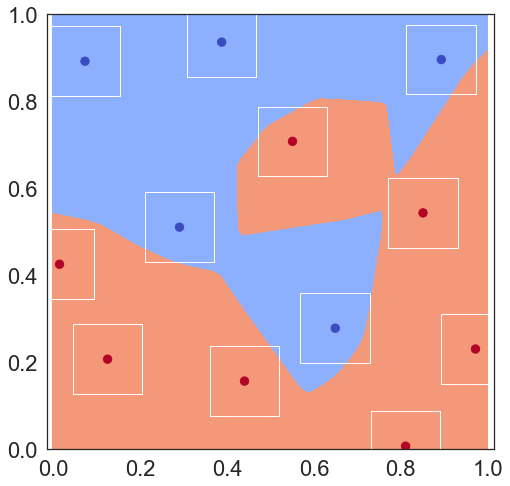

In [80]:
XX, YY = np.meshgrid(np.linspace(0, 1, 100), np.linspace(0, 1, 100))
X0 = Variable(torch.Tensor(np.stack([np.ravel(XX), np.ravel(YY)]).T))
y0 = net(X0)
ZZ = (y0[:,0] - y0[:,1]).resize(100,100).data.numpy()

fig, ax = plt.subplots(figsize=(8,8))
ax.contourf(XX,YY,-ZZ, cmap="coolwarm", levels=np.linspace(-1000,1000,3))
ax.scatter(X.numpy()[:,0], X.numpy()[:,1], c=y.numpy(), cmap="coolwarm", s=70)
ax.axis("equal")
ax.axis([0,1,0,1])

for a in x:
    ax.add_patch(patches.Rectangle((a[0]-r/2, a[1]-r/2), r, r, fill=False))

## Robust Neural Network

In [81]:
import sys
sys.path.append("../")
from convex_adversarial import robust_loss

torch.manual_seed(1)
robust_net = nn.Sequential(
    nn.Linear(2,100),
    nn.ReLU(),
    nn.Linear(100,100),
    nn.ReLU(),
    nn.Linear(100,100),
    nn.ReLU(),
    nn.Linear(100,100),
    nn.ReLU(),
    nn.Linear(100,2)
)
data = []
opt = optim.Adam(robust_net.parameters(), lr=1e-3)
for i in range(1000):
    robust_ce, robust_err = robust_loss(robust_net, epsilon, Variable(X), Variable(y))
    out = robust_net(Variable(X))
    l2 = nn.CrossEntropyLoss()(out, Variable(y))
    err = (out.max(1)[1].data != y).float().mean()
    data.append([l2.item(), robust_ce.item(), err, robust_err])
    if i % 100 == 0:
        print(robust_ce.item(), robust_err)
    opt.zero_grad()
    (robust_ce).backward()
    opt.step()

print(l2.data.item(), robust_ce.item(), robust_err)

0.6903979182243347 tensor(0)
0.5521818995475769 tensor(0)
0.343895822763443 tensor(0)
0.14605598151683807 tensor(0)
0.0808156207203865 tensor(0)
0.04092000052332878 tensor(0)
0.016822567209601402 tensor(0)
0.008793358691036701 tensor(0)
0.006006373558193445 tensor(0)
2.346898078918457 tensor(0)
0.0004530151782091707 0.06348026543855667 tensor(0)


### Visualization: learned robust classifier

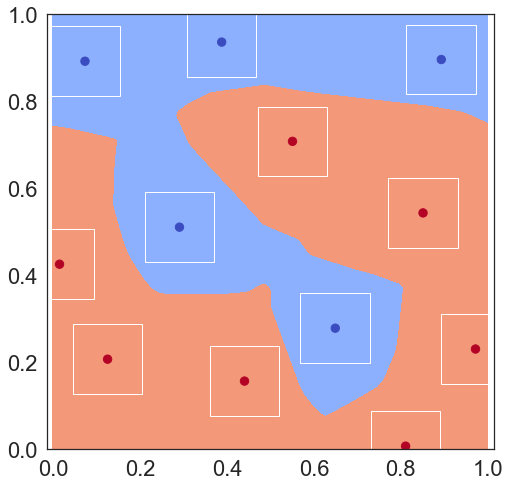

In [82]:
XX, YY = np.meshgrid(np.linspace(0, 1, 100), np.linspace(0, 1, 100))
X0 = Variable(torch.Tensor(np.stack([np.ravel(XX), np.ravel(YY)]).T))
y0 = robust_net(X0)
ZZ = (y0[:,0] - y0[:,1]).resize(100,100).data.numpy()

fig, ax = plt.subplots(figsize=(8,8))
ax.contourf(XX,YY,-ZZ, cmap="coolwarm", levels=np.linspace(-1000,1000,3))
ax.scatter(X.numpy()[:,0], X.numpy()[:,1], c=y.numpy(), cmap="coolwarm", s=70)
ax.axis("equal")
ax.axis([0,1,0,1])

for a in x:
    ax.add_patch(patches.Rectangle((a[0]-r/2, a[1]-r/2), r, r, fill=False))

# Grid plots

In [83]:
def plot_grid(net, ax): 
    XX, YY = np.meshgrid(np.linspace(-0.1, 1.1, 100), np.linspace(-0.1, 1.1, 100))
    X0 = Variable(torch.Tensor(np.stack([np.ravel(XX), np.ravel(YY)]).T))
    y0 = net(X0)
    ZZ = (y0[:,0] - y0[:,1]).resize(100,100).data.numpy()

    ax.contourf(XX,YY,-ZZ, cmap="coolwarm", levels=np.linspace(-1000,1000,3))
    ax.scatter(X.numpy()[:,0], X.numpy()[:,1], c=y.numpy(), cmap="coolwarm", s=70)
#     ax.axis("equal")
    ax.axis([0,1,0,1])

    for a in x:
        ax.add_patch(patches.Rectangle((a[0]-r/2, a[1]-r/2), r, r, fill=False))
    ax.set_yticks([0.0, 0.5, 1.0])
#     ax.set_xticks([])

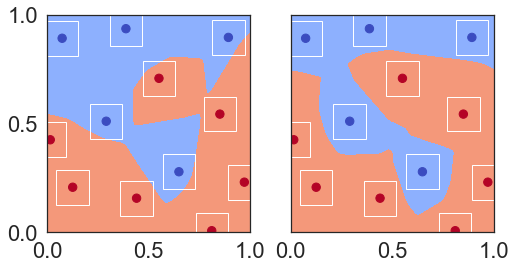

In [84]:
fig, axs = plt.subplots(1,2,figsize=(8,4), sharex=True, sharey=True)
plot_grid(net, axs[0])
plot_grid(robust_net, axs[1])
# plt.tight_layout()
plt.savefig('2D_grid.pdf', bbox_inches='tight')

# Learning curves

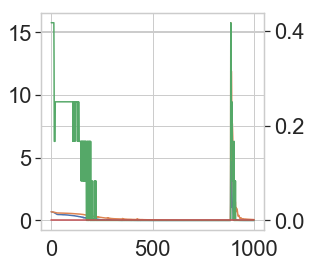

In [85]:
seaborn.set_style("whitegrid")
d = np.array(data)
fig, ax_loss = plt.subplots(1,1,figsize=(4,4))
ax_loss.plot(d[:,0], color='C0')
ax_loss.plot(d[:,1], color='C1')
ax_err = ax_loss.twinx()
ax_err.plot(d[:,2], color='C2')
ax_err.plot(d[:,3], color='C3')

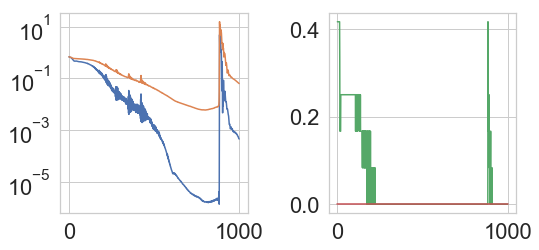

In [86]:
seaborn.set_style("whitegrid")
d = np.array(data)
fig, axs = plt.subplots(1,2,figsize=(8,4))
axs[0].semilogy(d[:,0], color='C0')
axs[0].semilogy(d[:,1], color='C1')
axs[1].plot(d[:,2], color='C2')
axs[1].plot(d[:,3], color='C3')
plt.tight_layout()
plt.savefig('2D_curves.pdf', bbox_inches='tight')

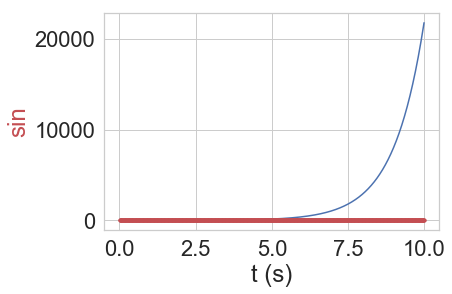

In [87]:

ax1 = plt.plot()
t = np.arange(0.01, 10.0, 0.01)
s1 = np.exp(t)
plt.plot(t,s1,'b-')
plt.xlabel('t (s)')
plt.ylabel('exp',color='b')

ax2 = plt.plot()
s2 = np.sin(2*np.pi*t)
plt.plot(t, s2, 'r.')
plt.ylabel('sin', color='r')
plt.show()